In [416]:
import datetime

import pandas as pd

# load a time series of univariate data
# for now just load this one dataset https://raw.githubusercontent.com/waico/SKAB/master/data/valve1/2.csv

# load the dataset (; separated)
series = pd.read_csv(
	'https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_GOOG.csv', header=0,
	index_col=0, parse_dates=True, delimiter=',')

In [417]:
# show the first few rows of the dataset
print(series.head(2))

                     value
timestamp                 
2015-02-26 21:42:53     35
2015-02-26 21:47:53     41


In [418]:
# instead, let's generate a dataset where the data follows a more interesting pattern
# and then we can add some noise to it
# pattern: y = 2x^2 + 300
# noise: normal distribution with mean 0 and std dev 1

import numpy as np
import datetime
base_data = np.array([2 * i*i + 300000 for i in range(1000)])

# add noise
noise = np.random.normal(100000, 100000, 1000)
noisy_data = base_data + noise

# add some anomalies
# at each point, 5% chance of failed sensor reading (0)
for i in range(1000):
	if np.random.rand() < 0.05:
		noisy_data[i] = 0

# create a time series
series = pd.DataFrame(noisy_data, index=[datetime.datetime.now() + datetime.timedelta(seconds=i) for i in range(1000)])

# set the column name
series.columns = ["value"]



In [419]:
# convert timestamps to # of seconds since first observations
first_observation = series.index.min()

series.index = series.index.map(lambda x: (x - first_observation).seconds)


In [420]:
series.index

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       990, 991, 992, 993, 994, 995, 996, 997, 998, 999],
      dtype='int64', length=1000)

In [421]:
series.head()

,value
0,540583.526636
1,519460.148718
2,335378.532929
3,467728.404330
4,465533.025082


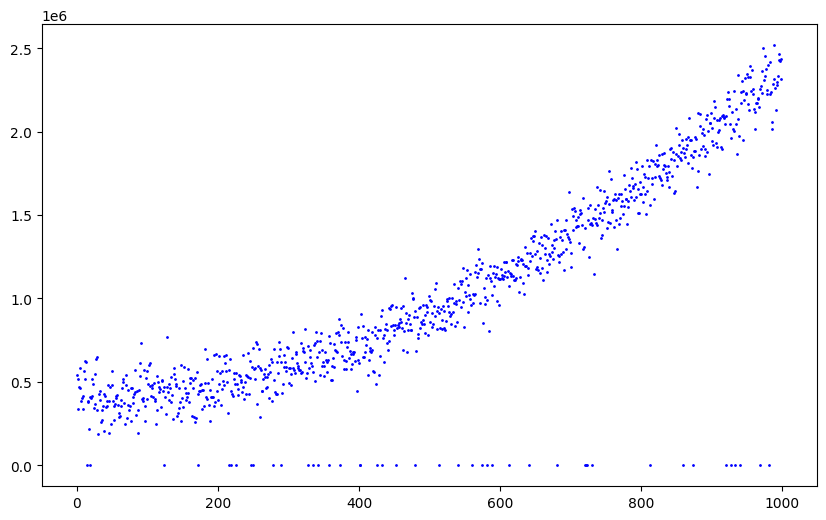

In [422]:
import matplotlib
from datetime import datetime
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))  # Optional: Adjusts the figure size

plt.scatter(series.index, series[series.columns[0]], color="blue",
			s=1)
# plt.yscale("log")
plt.show()

In [423]:
# this should be a really simple example. Let's start by finding the line of best fit

import numpy as np
n = 3
coefficients = np.polyfit(series.index, series.values, n)

# m, b = np.polyfit(series.index, series.values, 1)


In [424]:
# print("m: ", m, "b: ", b)

In [425]:
# plot that line
x_line = np.linspace(series.index.min(), series.index.max(), 100)  # More points for a smoother line
y_line = np.polyval(coefficients, x_line)


std_dev = np.std(series.values)

def expected_value(value):
    return np.polyval(coefficients, value)[0]

def is_anomaly(entry):
	expectation = expected_value(entry[0])
	diff = abs(expectation - entry[1]).values[0]
	# print("diff type", type(diff), "equals", diff)
	# print("expectation type", type(expectation), "equals", expectation)
	result = bool((diff > std_dev) or (diff > 0.9*expectation))
	# print("result", result)
	return result


In [426]:
anomalies = [v for v in series.iterrows() if is_anomaly(v)]
non_anomalies = [v for v in series.iterrows() if not is_anomaly(v)]

In [427]:
def timestamp_value_list_x_y(input_list):
	x = [v[0] for v in input_list]
	y = [v[1] for v in input_list]
	return x, y

C:\Users\Ezra\AppData\Local\pypoetry\Cache\virtualenvs\cs365-DQ18TMOT-py3.9\lib\site-packages\matplotlib\cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


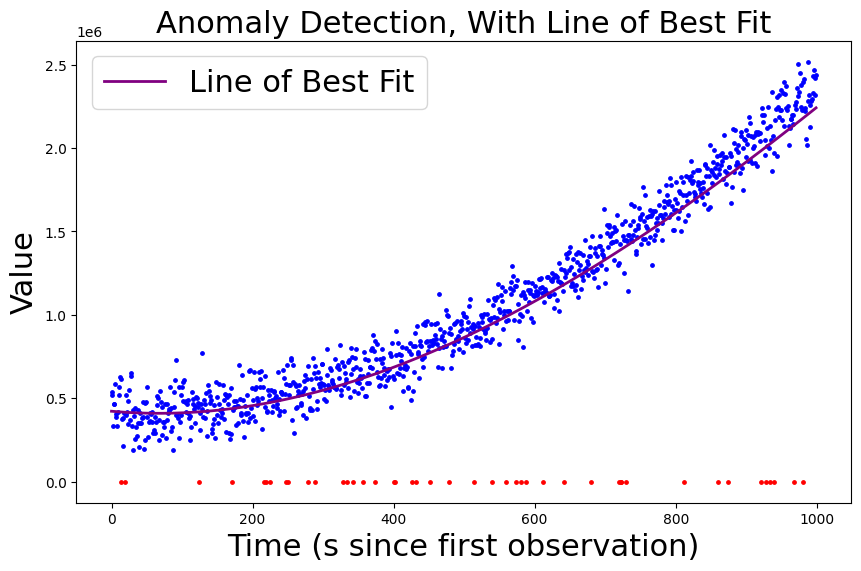

In [428]:
plt.show()

plt.figure(figsize=(10, 6))  # Optional: Adjusts the figure size
plt.plot(x_line, y_line, color='purple', label='Line of Best Fit', linewidth=2)

# Plots normal points in blue and anomalies in red
x_values, y_values = timestamp_value_list_x_y(non_anomalies)
x_anom_values, y_anom_values = timestamp_value_list_x_y(anomalies)
# plt.yscale("log")
plt.scatter(x_values, y_values, color="blue",s=6)
plt.scatter(x_anom_values, y_anom_values, color="red", s=6)

fontsize = 22

plt.xlabel("Time (s since first observation)", fontsize=fontsize)
plt.ylabel("Value", fontsize=fontsize)
plt.title("Anomaly Detection, With Line of Best Fit", fontsize=fontsize)
# increase font size
plt.legend(fontsize=22)
